In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!pip install hazm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 35.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 54.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 892.6/892.6 kB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 64.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 45.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.4
    Uninstalling numpy-1.24.4:
      Successfully uninstalled numpy-1.24.4
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.4
    Uninstalling nltk-3.2.4:
      Successfully uninstalled nltk-3.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.8.0 requires cubinlinker, which is not installed.
cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not 

In [3]:
import pandas as pd
from hazm import word_tokenize, stopwords_list, Normalizer, Lemmatizer

# Load the dataset
df = pd.read_csv("/kaggle/input/d/amirentezari/ganjoor-10-authors/persian_authors.csv")

# Define a normalizer to normalize the texts
normalizer = Normalizer()

# Tokenize, remove stopwords, and normalize the texts
def preprocess_text(text):
    # Normalize the text
    normalized_text = normalizer.normalize(text)

    # Tokenize the text
    tokens = word_tokenize(normalized_text)

    # Remove stopwords
    clean_tokens = [token for token in tokens if token not in stopwords_list()]

    # Join tokens back into a single string
    cleaned_text = ' '.join(clean_tokens)

    return cleaned_text


# Apply preprocessing to all texts in the dataset
df = df.dropna(subset=['text'])
df['text'] = df['text'].apply(preprocess_text)


def limit_df(text, n_word=500):
    try :
        return " ".join(text.split()[:n_word] if text else "")
    except:
        return "-"
texts = list(map(limit_df,list(df["text"])))

df["text"] = texts

df = df.sample(frac=1, random_state=42).reset_index(drop=True)



# Display the preprocessed dataset
print(df.head())


   Unnamed: 0.2  Unnamed: 0.1   author         b_name   p_name  \
0           351           351   eraghi         eraghi   eraghi   
1             9             9  moulavi        moulavi  moulavi   
2            57            57    attar  manteghotteyr      NaN   
3            60            60    attar  manteghotteyr      NaN   
4            25            25  moulavi        moulavi  moulavi   

                                                text  Unnamed: 0  
0  سحر صد ناله زاری صبا ز پیغامی آرد سر کوی باد م...         NaN  
1  ای عاشقان‌ای عاشقان گه وصل لقا آسمان ندا کای م...         NaN  
2  درویشی ز فرط عشق زار وز محبت همچو آتش بی‌قرار ...         NaN  
3  محتسب مرد می‌زد زور مست ای محتسب کن شور زانک ک...         NaN  
4  بشکن چنگ را‌ای معلا ! هزاران چنگ هست چو چنگ عش...         NaN  


In [4]:
print(df.head())

   Unnamed: 0.2  Unnamed: 0.1   author         b_name   p_name  \
0           351           351   eraghi         eraghi   eraghi   
1             9             9  moulavi        moulavi  moulavi   
2            57            57    attar  manteghotteyr      NaN   
3            60            60    attar  manteghotteyr      NaN   
4            25            25  moulavi        moulavi  moulavi   

                                                text  Unnamed: 0  
0  سحر صد ناله زاری صبا ز پیغامی آرد سر کوی باد م...         NaN  
1  ای عاشقان‌ای عاشقان گه وصل لقا آسمان ندا کای م...         NaN  
2  درویشی ز فرط عشق زار وز محبت همچو آتش بی‌قرار ...         NaN  
3  محتسب مرد می‌زد زور مست ای محتسب کن شور زانک ک...         NaN  
4  بشکن چنگ را‌ای معلا ! هزاران چنگ هست چو چنگ عش...         NaN  


In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310 entries, 0 to 309
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0.2  310 non-null    int64  
 1   Unnamed: 0.1  310 non-null    int64  
 2   author        310 non-null    object 
 3   b_name        310 non-null    object 
 4   p_name        248 non-null    object 
 5   text          310 non-null    object 
 6   Unnamed: 0    0 non-null      float64
dtypes: float64(1), int64(2), object(4)
memory usage: 17.1+ KB
None


In [6]:
print(df.describe())

       Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0
count    310.000000    310.000000         0.0
mean     182.400000    182.400000         NaN
std      114.183614    114.183614         NaN
min        0.000000      0.000000         NaN
25%       77.250000     77.250000         NaN
50%      185.500000    185.500000         NaN
75%      293.750000    293.750000         NaN
max      371.000000    371.000000         NaN


In [7]:
print(df['author'].nunique())

10


In [8]:
print(df['author'].value_counts())

author
eraghi      31
moulavi     31
attar       31
rahi        31
iqbal       31
nezami      31
ferdousi    31
saeb        31
saadi       31
jami        31
Name: count, dtype: int64


In [9]:
df['text_length'] = df['text'].apply(len)
print(df['text_length'].describe())

count     310.000000
mean     2430.361290
std       167.080291
min      1961.000000
25%      2327.500000
50%      2461.500000
75%      2556.750000
max      2812.000000
Name: text_length, dtype: float64


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


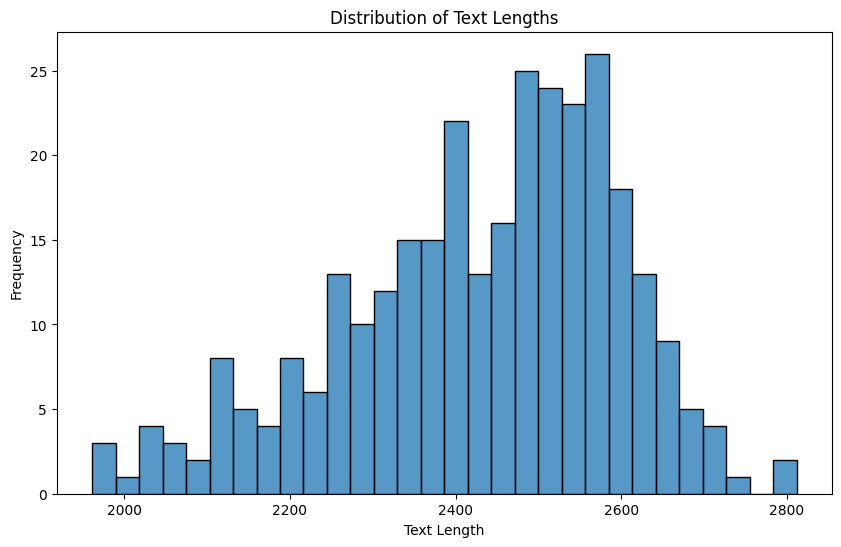

In [10]:
plt.figure(figsize=(10,6))
sns.histplot(data=df, x='text_length', bins=30)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

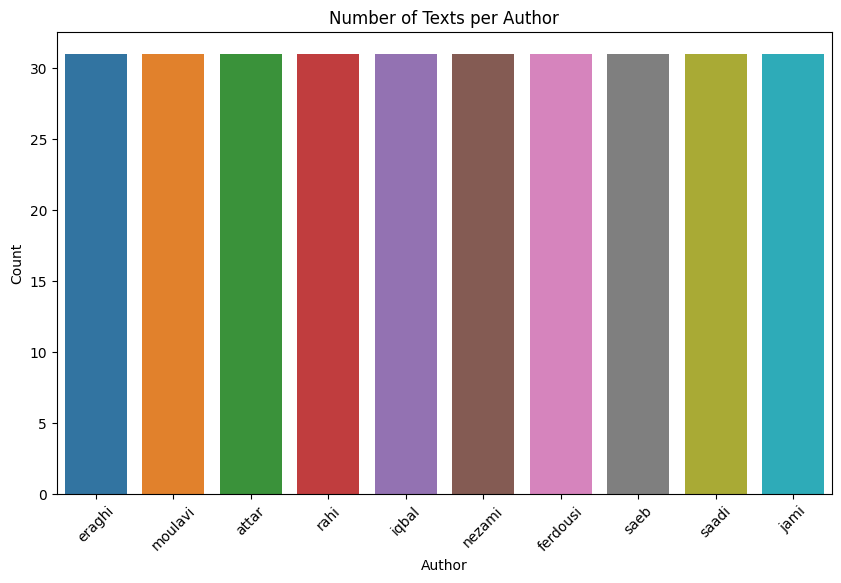

In [11]:
plt.figure(figsize=(10,6))
sns.countplot(data=df, x='author')
plt.title('Number of Texts per Author')
plt.xlabel('Author')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [12]:
print(df.groupby('author').apply(lambda x: x.sample(1)))

              Unnamed: 0.2  Unnamed: 0.1    author         b_name    p_name  \
author                                                                        
attar    213            32            32     attar  manteghotteyr       NaN   
eraghi   206           368           368    eraghi         eraghi    eraghi   
ferdousi 259           105           105  ferdousi       ferdousi  ferdousi   
iqbal    230           187           187     iqbal    asrar-khodi       NaN   
jami     195           327           327      jami           jami      jami   
moulavi  31              3             3   moulavi        moulavi   moulavi   
nezami   102           302           302    nezami         nezami    nezami   
rahi     183            89            89      rahi           rahi      rahi   
saadi    194           223           223     saadi          saadi     saadi   
saeb     106           185           185      saeb           saeb      saeb   

                                                   

/tmp/ipykernel_34/1583110036.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  print(df.groupby('author').apply(lambda x: x.sample(1)))


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

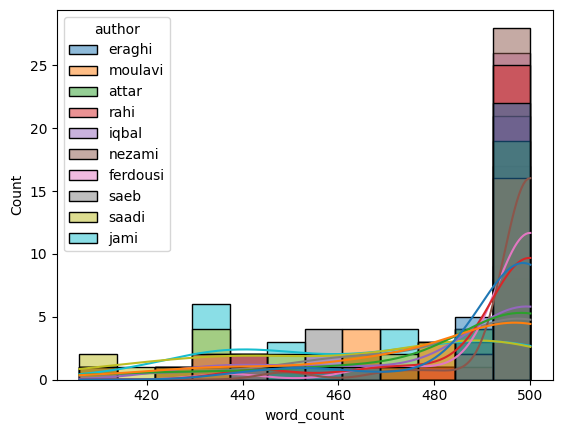

In [13]:
#Count spaces plus one for number of words
df['word_count'] = df['text'].str.count(' ') + 1

sns.histplot(data=df, x='word_count', hue='author', kde=True)
plt.show()

In [15]:
num_labels=len(df['author'].unique())

In [16]:
# Tokenize text data using a BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")

# Tokenize and pad sequences, and create attention masks
def tokenize_texts(texts, tokenizer, max_length=128):
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded_dict = tokenizer.encode_plus(
                            text,
                            add_special_tokens = True,
                            max_length = max_length,
                            padding = 'max_length',
                            truncation=True,
                            return_attention_mask = True,
                            return_tensors = 'pt'
                       )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

# Split dataset into train, validation, and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(df['text'], df['author'], test_size=0.2, random_state=42)
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=0.1, random_state=42)

# Tokenize the texts
train_input_ids, train_attention_masks = tokenize_texts(train_texts, tokenizer)
val_input_ids, val_attention_masks = tokenize_texts(val_texts, tokenizer)
test_input_ids, test_attention_masks = tokenize_texts(test_texts, tokenizer)

# Convert labels to integers
label_dict = {author: idx for idx, author in enumerate(df['author'].unique())}
train_labels = train_labels.map(label_dict)
val_labels = val_labels.map(label_dict)
test_labels = test_labels.map(label_dict)

# Convert labels to tensors
train_labels = torch.tensor(train_labels.values)
val_labels = torch.tensor(val_labels.values)
test_labels = torch.tensor(test_labels.values)


# Create DataLoader for each set
batch_size = 16

train_data = TensorDataset(train_input_ids, train_attention_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_input_ids, val_attention_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

test_data = TensorDataset(test_input_ids, test_attention_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)


tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [17]:
label_dict

{'eraghi': 0,
 'moulavi': 1,
 'attar': 2,
 'rahi': 3,
 'iqbal': 4,
 'nezami': 5,
 'ferdousi': 6,
 'saeb': 7,
 'saadi': 8,
 'jami': 9}

In [18]:
# Load pre-trained BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=len(df['author'].unique()))

# Define optimizer and learning rate
learning_rate = 2e-5  # Adjust the learning rate

optimizer = AdamW(model.parameters(), lr=learning_rate)

# Hyperparameters
epochs = 50  # Adjust the number of epochs
batch_size = 32  # Adjust the batch size

total_steps = len(train_dataloader) * epochs

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_steps)

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

best_val_accuracy = 0.0  # Track the best validation accuracy

# Lists to store the metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    train_accuracy = 0  # Track train accuracy

    for step, batch in enumerate(train_dataloader):
        batch_input_ids = batch[0].to(device)
        batch_attention_masks = batch[1].to(device)
        batch_labels = batch[2].to(device)

        model.zero_grad()

        outputs = model(batch_input_ids, attention_mask=batch_attention_masks, labels=batch_labels)
        loss = outputs.loss
        total_train_loss += loss.item()

        logits = outputs.logits
        logits = logits.detach().cpu().numpy()
        predictions = np.argmax(logits, axis=1)
        train_accuracy += accuracy_score(predictions, batch_labels.cpu().numpy())

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    avg_train_accuracy = train_accuracy / len(train_dataloader)
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_accuracy)

    # Validation loop
    model.eval()
    val_accuracy = 0
    val_loss = 0
    with torch.no_grad():
        for batch in val_dataloader:
            batch_input_ids = batch[0].to(device)
            batch_attention_masks = batch[1].to(device)
            batch_labels = batch[2].to(device)

            outputs = model(batch_input_ids, attention_mask=batch_attention_masks, labels=batch_labels)
            loss = outputs.loss
            val_loss += loss.item()

            logits = outputs.logits
            logits = logits.detach().cpu().numpy()
            predictions = np.argmax(logits, axis=1)
            val_accuracy += accuracy_score(predictions, batch_labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_dataloader)
    avg_val_accuracy = val_accuracy / len(val_dataloader)
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_accuracy)

    print(f"Epoch {epoch+1}/{epochs}:")
    print(f"  Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Train Accuracy: {avg_train_accuracy:.4f} | Val Accuracy: {avg_val_accuracy:.4f}")

    # Save the best model
    if avg_val_accuracy > best_val_accuracy:
        best_val_accuracy = avg_val_accuracy
        torch.save(model.state_dict(), "best_model.pt")

# Load the best model
model.load_state_dict(torch.load("best_model.pt"))

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/50:
  Train Loss: 2.3196 | Val Loss: 2.3387 | Train Accuracy: 0.1161 | Val Accuracy: 0.0000
Epoch 2/50:
  Train Loss: 2.3062 | Val Loss: 2.3037 | Train Accuracy: 0.1259 | Val Accuracy: 0.0868
Epoch 3/50:
  Train Loss: 2.1909 | Val Loss: 2.2601 | Train Accuracy: 0.2289 | Val Accuracy: 0.1250
Epoch 4/50:
  Train Loss: 2.0012 | Val Loss: 2.2464 | Train Accuracy: 0.3089 | Val Accuracy: 0.1181
Epoch 5/50:
  Train Loss: 1.8367 | Val Loss: 2.0979 | Train Accuracy: 0.3866 | Val Accuracy: 0.0938
Epoch 6/50:
  Train Loss: 1.6633 | Val Loss: 2.0786 | Train Accuracy: 0.4753 | Val Accuracy: 0.2118
Epoch 7/50:
  Train Loss: 1.4795 | Val Loss: 1.8386 | Train Accuracy: 0.5515 | Val Accuracy: 0.1562
Epoch 8/50:
  Train Loss: 1.2339 | Val Loss: 1.7497 | Train Accuracy: 0.7182 | Val Accuracy: 0.4167
Epoch 9/50:
  Train Loss: 1.0446 | Val Loss: 1.6590 | Train Accuracy: 0.8161 | Val Accuracy: 0.5590
Epoch 10/50:
  Train Loss: 0.8456 | Val Loss: 1.5668 | Train Accuracy: 0.8607 | Val Accuracy: 0.5521

<All keys matched successfully>

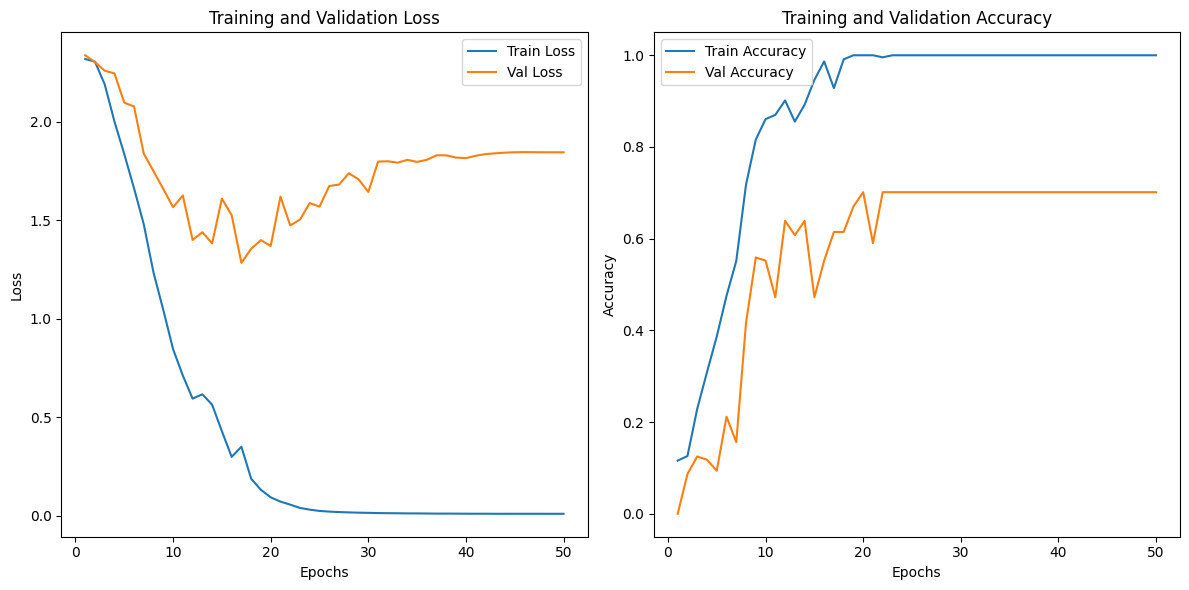

In [19]:
# Plot the metrics
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, val_accuracies, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Accuracy: 0.6129032258064516
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.33      0.40         3
           1       0.20      0.20      0.20         5
           2       1.00      0.50      0.67         4
           3       1.00      0.50      0.67         8
           4       0.67      0.44      0.53         9
           5       0.75      0.67      0.71         9
           6       0.75      0.86      0.80         7
           7       0.60      0.86      0.71         7
           8       0.50      1.00      0.67         3
           9       0.45      0.71      0.56         7

    accuracy                           0.61        62
   macro avg       0.64      0.61      0.59        62
weighted avg       0.67      0.61      0.61        62



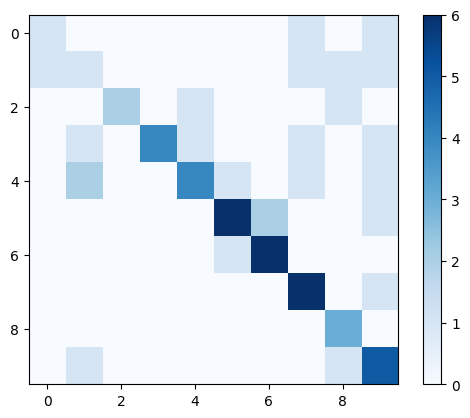

In [20]:
# Evaluation
model.eval()
all_predictions = []
all_true_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        batch_input_ids = batch[0].to(device)
        batch_attention_masks = batch[1].to(device)
        batch_labels = batch[2].to(device)

        outputs = model(batch_input_ids, attention_mask=batch_attention_masks)
        logits = outputs.logits
        logits = logits.detach().cpu().numpy()
        predictions = np.argmax(logits, axis=1)

        all_predictions.extend(predictions)
        all_true_labels.extend(batch_labels.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(all_true_labels, all_predictions)
print("Accuracy:", accuracy)

# Generate classification report
print("Classification Report:")
print(classification_report(all_true_labels, all_predictions))

# Generate confusion matrix
conf_matrix = confusion_matrix(all_true_labels, all_predictions)
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
plt.show()


In [21]:
# Load pre-trained BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained("xlm-roberta-base", num_labels=len(df['author'].unique()))

# Define optimizer and learning rate
learning_rate = 2e-5  # Adjust the learning rate

optimizer = AdamW(model.parameters(), lr=learning_rate)

# Hyperparameters
epochs = 50  # Adjust the number of epochs
batch_size = 32  # Adjust the batch size

total_steps = len(train_dataloader) * epochs

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_steps)

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

best_val_accuracy = 0.0  # Track the best validation accuracy

# Lists to store the metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    train_accuracy = 0  # Track train accuracy

    for step, batch in enumerate(train_dataloader):
        batch_input_ids = batch[0].to(device)
        batch_attention_masks = batch[1].to(device)
        batch_labels = batch[2].to(device)

        model.zero_grad()

        outputs = model(batch_input_ids, attention_mask=batch_attention_masks, labels=batch_labels)
        loss = outputs.loss
        total_train_loss += loss.item()

        logits = outputs.logits
        logits = logits.detach().cpu().numpy()
        predictions = np.argmax(logits, axis=1)
        train_accuracy += accuracy_score(predictions, batch_labels.cpu().numpy())

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    avg_train_accuracy = train_accuracy / len(train_dataloader)
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_accuracy)

    # Validation loop
    model.eval()
    val_accuracy = 0
    val_loss = 0
    with torch.no_grad():
        for batch in val_dataloader:
            batch_input_ids = batch[0].to(device)
            batch_attention_masks = batch[1].to(device)
            batch_labels = batch[2].to(device)

            outputs = model(batch_input_ids, attention_mask=batch_attention_masks, labels=batch_labels)
            loss = outputs.loss
            val_loss += loss.item()

            logits = outputs.logits
            logits = logits.detach().cpu().numpy()
            predictions = np.argmax(logits, axis=1)
            val_accuracy += accuracy_score(predictions, batch_labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_dataloader)
    avg_val_accuracy = val_accuracy / len(val_dataloader)
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_accuracy)

    print(f"Epoch {epoch+1}/{epochs}:")
    print(f"  Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Train Accuracy: {avg_train_accuracy:.4f} | Val Accuracy: {avg_val_accuracy:.4f}")

    # Save the best model
    if avg_val_accuracy > best_val_accuracy:
        best_val_accuracy = avg_val_accuracy
        torch.save(model.state_dict(), "best_model.pt")

# Load the best model
model.load_state_dict(torch.load("best_model.pt"))


config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

You are using a model of type xlm-roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNorm.wei

Epoch 1/50:
  Train Loss: 2.4174 | Val Loss: 2.3962 | Train Accuracy: 0.0896 | Val Accuracy: 0.0000
Epoch 2/50:
  Train Loss: 2.4123 | Val Loss: 2.4843 | Train Accuracy: 0.0762 | Val Accuracy: 0.0868
Epoch 3/50:
  Train Loss: 2.3449 | Val Loss: 2.4094 | Train Accuracy: 0.1217 | Val Accuracy: 0.0938
Epoch 4/50:
  Train Loss: 2.3365 | Val Loss: 2.2667 | Train Accuracy: 0.0810 | Val Accuracy: 0.0000
Epoch 5/50:
  Train Loss: 2.3216 | Val Loss: 2.3608 | Train Accuracy: 0.0762 | Val Accuracy: 0.0868
Epoch 6/50:
  Train Loss: 2.3106 | Val Loss: 2.3676 | Train Accuracy: 0.1170 | Val Accuracy: 0.0868
Epoch 7/50:
  Train Loss: 2.3425 | Val Loss: 2.4149 | Train Accuracy: 0.0896 | Val Accuracy: 0.0625
Epoch 8/50:
  Train Loss: 2.3443 | Val Loss: 2.2709 | Train Accuracy: 0.0860 | Val Accuracy: 0.0000
Epoch 9/50:
  Train Loss: 2.3199 | Val Loss: 2.4303 | Train Accuracy: 0.0943 | Val Accuracy: 0.0000
Epoch 10/50:
  Train Loss: 2.3191 | Val Loss: 2.3802 | Train Accuracy: 0.1122 | Val Accuracy: 0.0000

<All keys matched successfully>

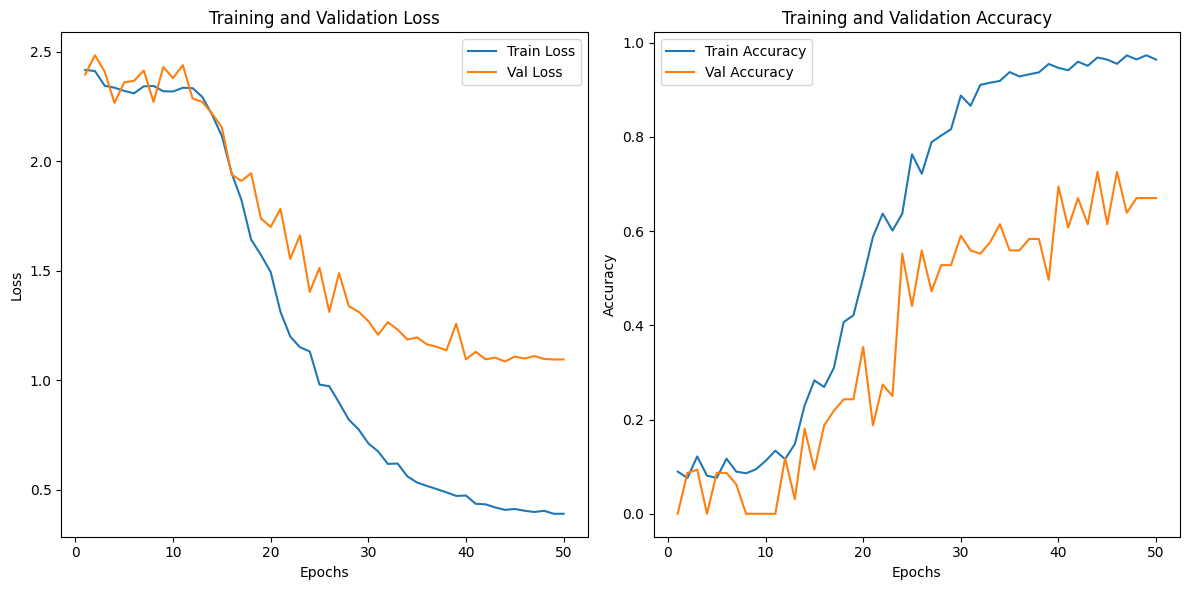

In [22]:
# Plot the metrics
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, val_accuracies, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Accuracy: 0.43548387096774194
Classification Report:
              precision    recall  f1-score   support

           0       0.17      0.33      0.22         3
           1       0.29      0.40      0.33         5
           2       0.00      0.00      0.00         4
           3       0.75      0.38      0.50         8
           4       0.38      0.33      0.35         9
           5       0.67      0.44      0.53         9
           6       0.86      0.86      0.86         7
           7       0.30      0.43      0.35         7
           8       0.43      1.00      0.60         3
           9       0.40      0.29      0.33         7

    accuracy                           0.44        62
   macro avg       0.42      0.45      0.41        62
weighted avg       0.48      0.44      0.43        62



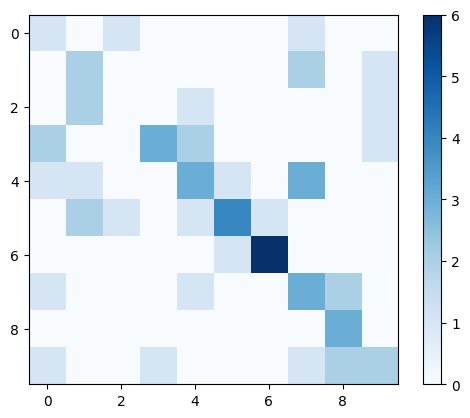

In [23]:
# Evaluation
model.eval()
all_predictions = []
all_true_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        batch_input_ids = batch[0].to(device)
        batch_attention_masks = batch[1].to(device)
        batch_labels = batch[2].to(device)

        outputs = model(batch_input_ids, attention_mask=batch_attention_masks)
        logits = outputs.logits
        logits = logits.detach().cpu().numpy()
        predictions = np.argmax(logits, axis=1)

        all_predictions.extend(predictions)
        all_true_labels.extend(batch_labels.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(all_true_labels, all_predictions)
print("Accuracy:", accuracy)

# Generate classification report
print("Classification Report:")
print(classification_report(all_true_labels, all_predictions))

# Generate confusion matrix
conf_matrix = confusion_matrix(all_true_labels, all_predictions)
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
plt.show()

In [24]:
# Load pre-trained BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained("distilbert-base-multilingual-cased", num_labels=len(df['author'].unique()))

# Define optimizer and learning rate
learning_rate = 2e-5  # Adjust the learning rate

optimizer = AdamW(model.parameters(), lr=learning_rate)

# Hyperparameters
epochs = 50  # Adjust the number of epochs
batch_size = 32  # Adjust the batch size

total_steps = len(train_dataloader) * epochs

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_steps)

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

best_val_accuracy = 0.0  # Track the best validation accuracy

# Lists to store the metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    train_accuracy = 0  # Track train accuracy

    for step, batch in enumerate(train_dataloader):
        batch_input_ids = batch[0].to(device)
        batch_attention_masks = batch[1].to(device)
        batch_labels = batch[2].to(device)

        model.zero_grad()

        outputs = model(batch_input_ids, attention_mask=batch_attention_masks, labels=batch_labels)
        loss = outputs.loss
        total_train_loss += loss.item()

        logits = outputs.logits
        logits = logits.detach().cpu().numpy()
        predictions = np.argmax(logits, axis=1)
        train_accuracy += accuracy_score(predictions, batch_labels.cpu().numpy())

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    avg_train_accuracy = train_accuracy / len(train_dataloader)
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_accuracy)

    # Validation loop
    model.eval()
    val_accuracy = 0
    val_loss = 0
    with torch.no_grad():
        for batch in val_dataloader:
            batch_input_ids = batch[0].to(device)
            batch_attention_masks = batch[1].to(device)
            batch_labels = batch[2].to(device)

            outputs = model(batch_input_ids, attention_mask=batch_attention_masks, labels=batch_labels)
            loss = outputs.loss
            val_loss += loss.item()

            logits = outputs.logits
            logits = logits.detach().cpu().numpy()
            predictions = np.argmax(logits, axis=1)
            val_accuracy += accuracy_score(predictions, batch_labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_dataloader)
    avg_val_accuracy = val_accuracy / len(val_dataloader)
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_accuracy)

    print(f"Epoch {epoch+1}/{epochs}:")
    print(f"  Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Train Accuracy: {avg_train_accuracy:.4f} | Val Accuracy: {avg_val_accuracy:.4f}")

    # Save the best model
    if avg_val_accuracy > best_val_accuracy:
        best_val_accuracy = avg_val_accuracy
        torch.save(model.state_dict(), "best_model.pt")

# Load the best model
model.load_state_dict(torch.load("best_model.pt"))

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.ou

Epoch 1/50:
  Train Loss: 2.4077 | Val Loss: 2.4688 | Train Accuracy: 0.0988 | Val Accuracy: 0.0938
Epoch 2/50:
  Train Loss: 2.4065 | Val Loss: 2.4200 | Train Accuracy: 0.0762 | Val Accuracy: 0.0000
Epoch 3/50:
  Train Loss: 2.3628 | Val Loss: 2.2453 | Train Accuracy: 0.0985 | Val Accuracy: 0.0312
Epoch 4/50:
  Train Loss: 2.3440 | Val Loss: 2.3805 | Train Accuracy: 0.1030 | Val Accuracy: 0.0000
Epoch 5/50:
  Train Loss: 2.3371 | Val Loss: 2.3926 | Train Accuracy: 0.0854 | Val Accuracy: 0.0868
Epoch 6/50:
  Train Loss: 2.3104 | Val Loss: 2.3203 | Train Accuracy: 0.1205 | Val Accuracy: 0.1111
Epoch 7/50:
  Train Loss: 2.3359 | Val Loss: 2.3421 | Train Accuracy: 0.0807 | Val Accuracy: 0.0000
Epoch 8/50:
  Train Loss: 2.3187 | Val Loss: 2.3449 | Train Accuracy: 0.1119 | Val Accuracy: 0.0868
Epoch 9/50:
  Train Loss: 2.3222 | Val Loss: 2.2910 | Train Accuracy: 0.1086 | Val Accuracy: 0.0000
Epoch 10/50:
  Train Loss: 2.3317 | Val Loss: 2.3451 | Train Accuracy: 0.1116 | Val Accuracy: 0.1181

<All keys matched successfully>

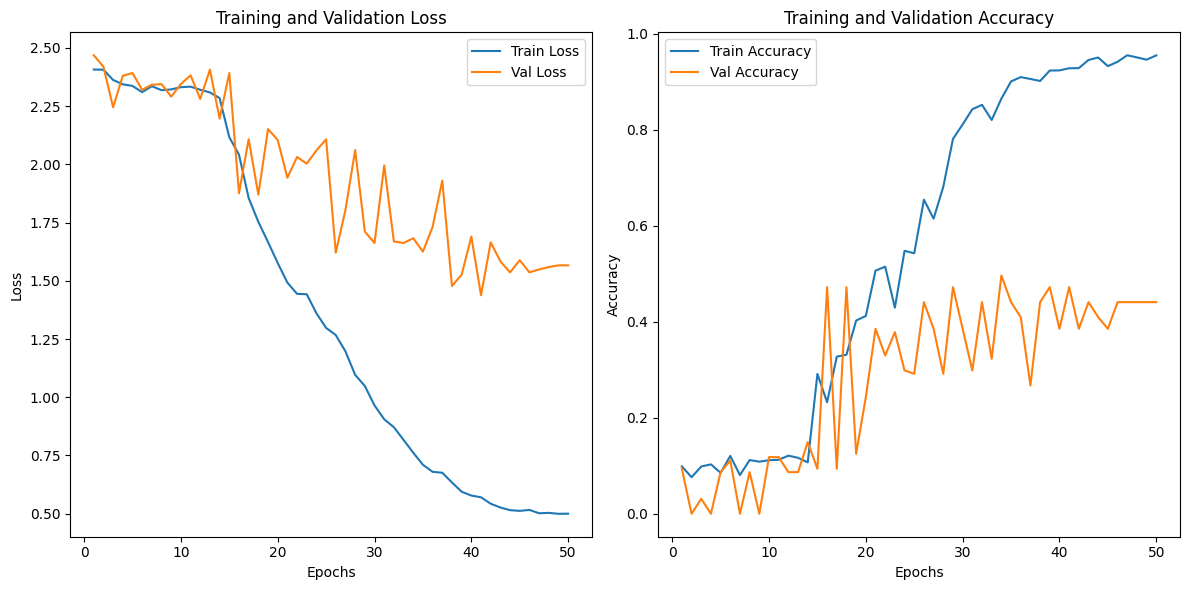

In [25]:
# Plot the metrics
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, val_accuracies, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Accuracy: 0.5161290322580645
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.20      0.20      0.20         5
           2       0.40      0.50      0.44         4
           3       0.75      0.38      0.50         8
           4       0.25      0.11      0.15         9
           5       0.58      0.78      0.67         9
           6       0.83      0.71      0.77         7
           7       0.54      1.00      0.70         7
           8       0.50      0.33      0.40         3
           9       0.45      0.71      0.56         7

    accuracy                           0.52        62
   macro avg       0.45      0.47      0.44        62
weighted avg       0.49      0.52      0.48        62



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


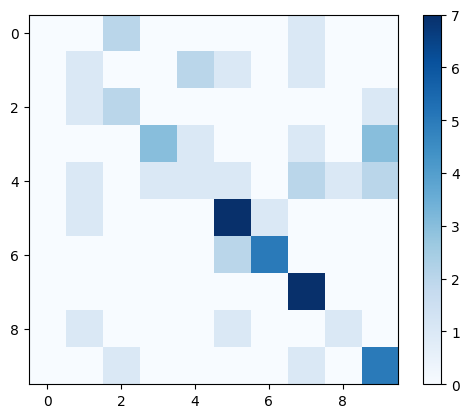

In [26]:
# Evaluation
model.eval()
all_predictions = []
all_true_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        batch_input_ids = batch[0].to(device)
        batch_attention_masks = batch[1].to(device)
        batch_labels = batch[2].to(device)

        outputs = model(batch_input_ids, attention_mask=batch_attention_masks)
        logits = outputs.logits
        logits = logits.detach().cpu().numpy()
        predictions = np.argmax(logits, axis=1)

        all_predictions.extend(predictions)
        all_true_labels.extend(batch_labels.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(all_true_labels, all_predictions)
print("Accuracy:", accuracy)

# Generate classification report
print("Classification Report:")
print(classification_report(all_true_labels, all_predictions))

# Generate confusion matrix
conf_matrix = confusion_matrix(all_true_labels, all_predictions)
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
plt.show()